In [40]:
import os
import torch
import math
import random
import pandas as pd
import numpy as np
from matplotlib.pyplot import hist
import matplotlib.pyplot as plt
from datetime  import datetime
from torch.utils.data import DataLoader
from sklearn.preprocessing import normalize
from config import TRAIN_DATA_LOC, TRAIN_LABELS_LOC, TEST_DATA_LOC, TEST_LABELS_LOC, SPLIT_TRAIN, BATCH_SIZE, RUN_DIR, EMBBEDINGS_NUMBER, MODELS_NUMBER, \
                   TRAIN_DS_IND, VALID_DS_IND, TEST_DS_IND, EPOCHS, MODELS_SAVE_PATH, MIN_LOSS_SAVE, EARLY_STOP_DIFF, EMBBEDINGS_REDUCED, LINEAR_INIT, BILINEAR_INIT
from helper import NeuralNetwork7, one_epoch_run, create_dataloaders, get_optimizer, parse_arguments, initialize_weights , select_train_valid
IMAGES_TYPE = 0

def select_train_valid(train_data, split_train):
    models_num, imgs_num, embs_num = train_data.shape
    total_pairs_mask_img_num = (imgs_num // 2) / models_num
    train_mask_imgs_num = math.ceil((total_pairs_mask_img_num) * split_train / 2.0) * 2
    valid_mask_imgs_num = int(total_pairs_mask_img_num - train_mask_imgs_num)
    mask_data_chunck = np.r_[np.ones(train_mask_imgs_num), np.zeros(valid_mask_imgs_num)].astype(bool)
    random.seed(1)
    random.shuffle(mask_data_chunck)
    mask = np.tile(mask_data_chunck, models_num)
    return mask


In [46]:
data = torch.load(TRAIN_DATA_LOC)
labels = torch.load(TRAIN_LABELS_LOC)
test_data = torch.load(TEST_DATA_LOC)[IMAGES_TYPE,:,:]
test_labels = torch.load(TEST_LABELS_LOC)
mask = select_train_valid(data, SPLIT_TRAIN)

# mask = mask[:11000]
# data = data[:,:22000,:]

In [47]:
train_data = data[IMAGES_TYPE, np.repeat(mask, 2), :]
train_labels = labels[:len(mask)][mask]
valid_data = data[IMAGES_TYPE, ~np.repeat(mask, 2), :]
valid_labels = labels[:len(mask)][~mask]

thresholds = np.arange(0, 4, 0.01)

norm1 = normalize(train_data[0::2])
norm2 = normalize(train_data[1::2])
diff = np.subtract(norm1, norm2)
train_dist = np.sum(np.square(diff), 1)
train_df = pd.DataFrame(train_dist, columns=['aa'])

norm1 = normalize(valid_data[0::2])
norm2 = normalize(valid_data[1::2])
diff = np.subtract(norm1, norm2)
valid_dist = np.sum(np.square(diff), 1)
vaild_df = pd.DataFrame(valid_dist, columns=['aa'])

same/different pairs ratio:  0.49977272727272726
same/different pairs ratio:  0.5009090909090909
same/different pairs ratio:  0.5


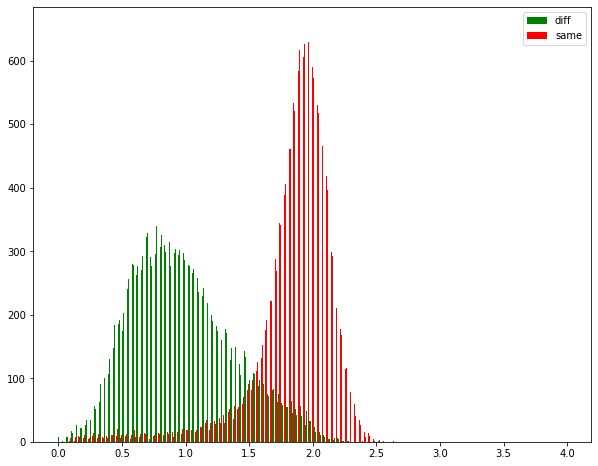

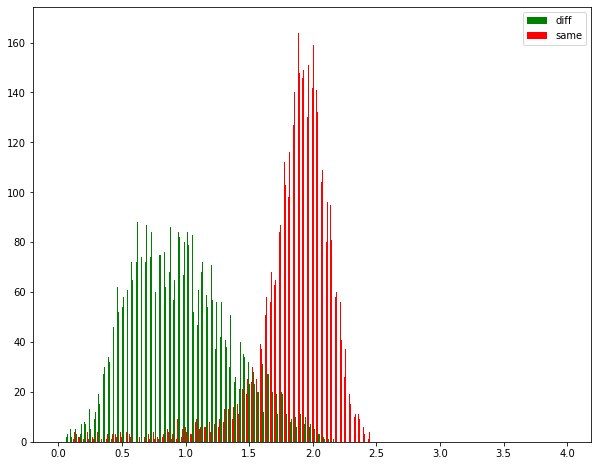

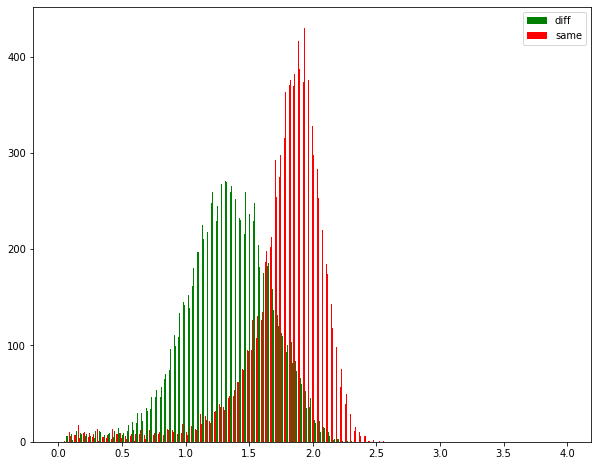

In [57]:
def plotit(curr_data, curr_labels):
    norm1 = normalize(curr_data[0::2])
    norm2 = normalize(curr_data[1::2])
    diff = np.subtract(norm1, norm2)
    dist = np.sum(np.square(diff), 1)
    same_person = dist[curr_labels]
    diff_person = dist[~curr_labels]
    print('same/different pairs ratio: ', sum(curr_labels)/len(curr_labels))    
    plt.figure(figsize=(10,8))
    thresholds = np.arange(0, 4, 0.01)
#     train_same_person = list(np.concatenate( plabels[labels], axis=0))
#     train_diff_person = list(np.concatenate( plabels[~labels], axis=0))
    _ = hist([same_person, diff_person], bins=thresholds, color=['green', 'red'], label=['same','diff'])
    plt.legend(['diff', 'same'])

plotit(train_data, train_labels)
plotit(valid_data, valid_labels)
plotit(test_data, test_labels)

Text(1.56, 120, '1.56')

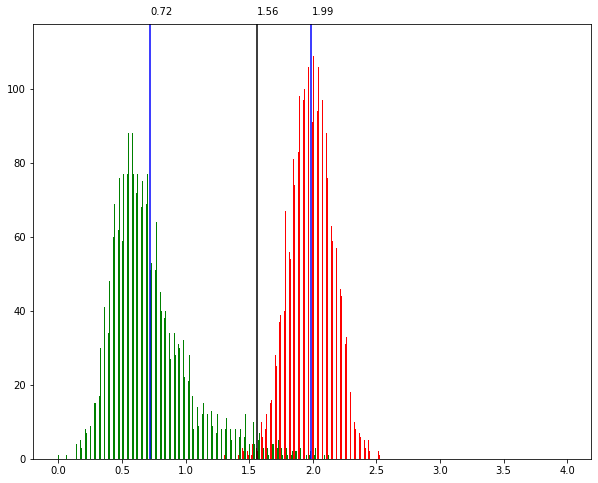

In [33]:
plt.figure(figsize=(10,8))
train_same_person = train_dist[train_labels]
train_diff_person =train_dist[~train_labels]
_ = hist([train_same_person, train_diff_person], bins=thresholds, color=['green', 'red'], label=['same','diff'])
plt.axvline(np.average(train_same_person),color ='blue')
plt.text(np.round(np.average(train_same_person),2),120,np.round(np.average(train_same_person),2))
plt.axvline(np.average(train_diff_person),color ='blue')
plt.text(np.round(np.average(train_diff_person),2),120,np.round(np.average(train_diff_person),2))

plt.axvline(1.56,color ='black')
plt.text(1.56,120,1.56)
